In [27]:
import astropy
from astropy.table import Table, vstack, Column
from astropy.io import fits
import dace
np.random.seed(13)

In [2]:
from utils import *

#### stellar sample

These stars are all HARPS GTO targets (as uniformly characterized by Sousa et al. 2008) with measured vsini (as non-uniformly measured and compiled in Glebocki et al. 2006).

In [51]:
t = Table.read('sousa-vsini-xmatch.vot', format='votable')

/Users/mbedell/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


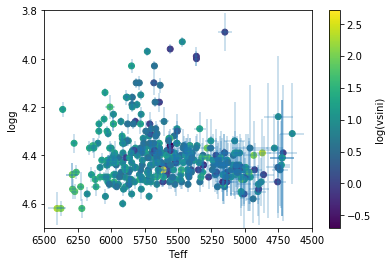

In [4]:
plt.errorbar(t['Teff'], t['logg'], xerr=t['e_Teff'], yerr=t['e_logg'], fmt='none',  alpha=0.3)
plt.scatter(t['Teff'], t['logg'], c=np.log(t['vsini']))
plt.ylim([4.7,3.8])
plt.xlim([6500,4500])
plt.colorbar(label='log(vsini)')
plt.xlabel('Teff')
plt.ylabel('logg');

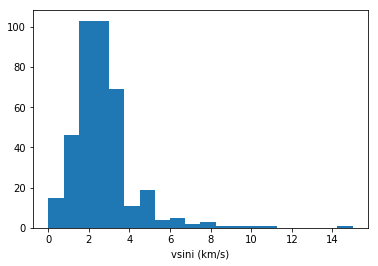

In [5]:
plt.hist(t['vsini'], bins=20)
plt.xlabel('vsini (km/s)');

#### fetch spectra

In [6]:
#stars = np.random.choice(t, 200, replace=False)
stars = t

In [7]:
%%capture
targets = []
err_rvs = []
for s in stars:
    starname = str(s['Star']).strip("'").strip("b'").replace(" ", "") # SUCH A HACK
    files = download_spectra(starname)
    if files is not None:
        for f in files:
            wave, flux = read_spectrum(f)
            err_rv = calc_rv_err(wave, flux)
            targets.append(s['Star'])
            err_rvs.append(err_rv)

2020-02-12 16:46:16,978 - INFO - File downloading on location : HD142.tar.gz


 Download : 2 MB

2020-02-12 16:46:21,376 - INFO - File downloaded on location : HD142.tar.gz



Download done


/Users/mbedell/python/thethethe/utils.py:50: RuntimeWarning: divide by zero encountered in true_divide
  err_rv_perpix = err_flux / df_dv
/Users/mbedell/python/thethethe/utils.py:50: RuntimeWarning: invalid value encountered in true_divide
  err_rv_perpix = err_flux / df_dv
2020-02-12 16:46:22,303 - INFO - File downloading on location : HD361.tar.gz


 Download : 1 MB

2020-02-12 16:46:25,773 - INFO - File downloaded on location : HD361.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:46:26,514 - INFO - File downloading on location : HD750.tar.gz


 Download : 1 MB

2020-02-12 16:46:29,974 - INFO - File downloaded on location : HD750.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:46:30,694 - INFO - File downloading on location : HD870.tar.gz


 Download : 2 MB

2020-02-12 16:46:33,333 - INFO - File downloaded on location : HD870.tar.gz



Download done


2020-02-12 16:46:34,203 - INFO - File downloading on location : HD967.tar.gz


 Download : 1 MB

2020-02-12 16:46:35,916 - INFO - File downloaded on location : HD967.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:46:36,836 - INFO - File downloading on location : HD1237.tar.gz
2020-02-12 16:46:37,796 - INFO - File downloaded on location : HD1237.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:46:38,682 - INFO - File downloading on location : HD1320.tar.gz


 Download : 2 MB

2020-02-12 16:46:40,501 - INFO - File downloaded on location : HD1320.tar.gz



Download done


2020-02-12 16:46:41,353 - INFO - File downloading on location : HD1388.tar.gz


 Download : 1 MB

2020-02-12 16:46:43,542 - INFO - File downloaded on location : HD1388.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:46:44,555 - INFO - File downloading on location : HD1461.tar.gz
2020-02-12 16:46:45,452 - INFO - File downloaded on location : HD1461.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:46:46,464 - INFO - File downloading on location : HD1581.tar.gz


 Download : 1 MB

2020-02-12 16:46:48,463 - INFO - File downloaded on location : HD1581.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:46:49,439 - INFO - File downloading on location : HD2025.tar.gz


 Download : 1 MB

2020-02-12 16:46:51,359 - INFO - File downloaded on location : HD2025.tar.gz


 Download : 2 MB
Download done
Insufficient data returned for HD2071


2020-02-12 16:46:52,614 - INFO - File downloading on location : HD2638.tar.gz
2020-02-12 16:46:53,294 - INFO - File downloaded on location : HD2638.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:46:54,050 - INFO - File downloading on location : HD3823.tar.gz


 Download : 1 MB

2020-02-12 16:46:56,171 - INFO - File downloaded on location : HD3823.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:46:57,016 - INFO - File downloading on location : HD4208.tar.gz


 Download : 1 MB

2020-02-12 16:46:58,019 - INFO - File downloaded on location : HD4208.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:46:58,882 - INFO - File downloading on location : HD4307.tar.gz


 Download : 2 MB

2020-02-12 16:47:00,371 - INFO - File downloaded on location : HD4307.tar.gz



Download done


2020-02-12 16:47:01,187 - INFO - File downloading on location : HD4308.tar.gz
2020-02-12 16:47:02,153 - INFO - File downloaded on location : HD4308.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:47:02,971 - INFO - File downloading on location : HD4915.tar.gz


 Download : 2 MB

2020-02-12 16:47:05,282 - INFO - File downloaded on location : HD4915.tar.gz



Download done


2020-02-12 16:47:06,031 - INFO - File downloading on location : HD6348.tar.gz


 Download : 1 MB

2020-02-12 16:47:07,946 - INFO - File downloaded on location : HD6348.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:47:08,693 - INFO - File downloading on location : HD6673.tar.gz
2020-02-12 16:47:09,744 - INFO - File downloaded on location : HD6673.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:47:10,535 - INFO - File downloading on location : HD6735.tar.gz


 Download : 2 MB

2020-02-12 16:47:11,440 - INFO - File downloaded on location : HD6735.tar.gz



Download done


2020-02-12 16:47:12,270 - INFO - File downloading on location : HD7134.tar.gz


 Download : 1 MB

2020-02-12 16:47:14,810 - INFO - File downloaded on location : HD7134.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:47:16,294 - INFO - File downloading on location : HD7449.tar.gz


 Download : 1 MB

2020-02-12 16:47:17,914 - INFO - File downloaded on location : HD7449.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:47:18,826 - INFO - File downloading on location : HD8326.tar.gz
2020-02-12 16:47:19,779 - INFO - File downloaded on location : HD8326.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:47:20,729 - INFO - File downloading on location : HD8389A.tar.gz


 Download : 2 MB

2020-02-12 16:47:23,511 - INFO - File downloaded on location : HD8389A.tar.gz



Download done


2020-02-12 16:47:24,247 - INFO - File downloading on location : HD8406.tar.gz


 Download : 2 MB

2020-02-12 16:47:25,863 - INFO - File downloaded on location : HD8406.tar.gz



Download done


2020-02-12 16:47:26,612 - INFO - File downloading on location : HD8638.tar.gz


 Download : 2 MB

2020-02-12 16:47:27,695 - INFO - File downloaded on location : HD8638.tar.gz



Download done


2020-02-12 16:47:28,453 - INFO - File downloading on location : HD8828.tar.gz


 Download : 2 MB

2020-02-12 16:47:30,165 - INFO - File downloaded on location : HD8828.tar.gz



Download done


2020-02-12 16:47:30,923 - INFO - File downloading on location : HD8828.tar.gz
2020-02-12 16:47:31,845 - INFO - File downloaded on location : HD8828.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:47:32,653 - INFO - File downloading on location : HD8859.tar.gz


 Download : 1 MB

2020-02-12 16:47:34,833 - INFO - File downloaded on location : HD8859.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:47:35,569 - INFO - File downloading on location : HD8912.tar.gz


 Download : 2 MB

2020-02-12 16:47:36,599 - INFO - File downloaded on location : HD8912.tar.gz



Download done


2020-02-12 16:47:37,364 - INFO - File downloading on location : HD9246.tar.gz


 Download : 2 MB

2020-02-12 16:47:38,341 - INFO - File downloaded on location : HD9246.tar.gz



Download done


2020-02-12 16:47:39,409 - INFO - File downloading on location : HD9782.tar.gz


 Download : 1 MB

2020-02-12 16:47:41,260 - INFO - File downloaded on location : HD9782.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:47:41,972 - INFO - File downloading on location : HD10002.tar.gz


 Download : 2 MB

2020-02-12 16:47:44,194 - INFO - File downloaded on location : HD10002.tar.gz



Download done


2020-02-12 16:47:44,942 - INFO - File downloading on location : HD10166.tar.gz


 Download : 1 MB

2020-02-12 16:47:46,595 - INFO - File downloaded on location : HD10166.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:47:47,421 - INFO - File downloading on location : HD10180.tar.gz


 Download : 2 MB

2020-02-12 16:47:49,416 - INFO - File downloaded on location : HD10180.tar.gz



Download done


2020-02-12 16:47:50,265 - INFO - File downloading on location : HD10647.tar.gz


 Download : 2 MB

2020-02-12 16:47:53,515 - INFO - File downloaded on location : HD10647.tar.gz



Download done


2020-02-12 16:47:54,391 - INFO - File downloading on location : HD10700.tar.gz


 Download : 1 MB

2020-02-12 16:47:56,105 - INFO - File downloaded on location : HD10700.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:47:57,059 - INFO - File downloading on location : HD10700.tar.gz
2020-02-12 16:47:57,964 - INFO - File downloaded on location : HD10700.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:47:58,763 - INFO - File downloading on location : HD11226.tar.gz
2020-02-12 16:47:59,826 - INFO - File downloaded on location : HD11226.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:00,609 - INFO - File downloading on location : HD11505.tar.gz


 Download : 2 MB

2020-02-12 16:48:01,691 - INFO - File downloaded on location : HD11505.tar.gz



Download done


2020-02-12 16:48:02,677 - INFO - File downloading on location : HD12387.tar.gz


 Download : 1 MB

2020-02-12 16:48:04,252 - INFO - File downloaded on location : HD12387.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:05,115 - INFO - File downloading on location : HD13060.tar.gz
2020-02-12 16:48:06,063 - INFO - File downloaded on location : HD13060.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:06,854 - INFO - File downloading on location : HD13724.tar.gz


 Download : 1 MB

2020-02-12 16:48:08,552 - INFO - File downloaded on location : HD13724.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:09,413 - INFO - File downloading on location : HD13808.tar.gz


 Download : 1 MB

2020-02-12 16:48:10,830 - INFO - File downloaded on location : HD13808.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:11,564 - INFO - File downloading on location : HD14374.tar.gz


 Download : 1 MB

2020-02-12 16:48:13,627 - INFO - File downloaded on location : HD14374.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:14,434 - INFO - File downloading on location : HD14680.tar.gz


 Download : 1 MB

2020-02-12 16:48:15,940 - INFO - File downloaded on location : HD14680.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:16,687 - INFO - File downloading on location : HD14747.tar.gz


 Download : 2 MB

2020-02-12 16:48:17,749 - INFO - File downloaded on location : HD14747.tar.gz



Download done


2020-02-12 16:48:18,524 - INFO - File downloading on location : HD15337.tar.gz


 Download : 1 MB

2020-02-12 16:48:20,004 - INFO - File downloaded on location : HD15337.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:20,789 - INFO - File downloading on location : HD16141.tar.gz
2020-02-12 16:48:21,738 - INFO - File downloaded on location : HD16141.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:22,469 - INFO - File downloading on location : HD16297.tar.gz


 Download : 2 MB

2020-02-12 16:48:24,438 - INFO - File downloaded on location : HD16297.tar.gz



Download done


2020-02-12 16:48:25,287 - INFO - File downloading on location : HD16417.tar.gz
2020-02-12 16:48:26,244 - INFO - File downloaded on location : HD16417.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:27,164 - INFO - File downloading on location : HD16714.tar.gz


 Download : 1 MB

2020-02-12 16:48:29,209 - INFO - File downloaded on location : HD16714.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:29,916 - INFO - File downloading on location : HD17051.tar.gz


 Download : 1 MB

2020-02-12 16:48:30,889 - INFO - File downloaded on location : HD17051.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:31,636 - INFO - File downloading on location : HD17970.tar.gz


 Download : 1 MB

2020-02-12 16:48:33,741 - INFO - File downloaded on location : HD17970.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:34,500 - INFO - File downloading on location : HD19034.tar.gz
2020-02-12 16:48:35,573 - INFO - File downloaded on location : HD19034.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:36,348 - INFO - File downloading on location : HD19467.tar.gz


 Download : 1 MB

2020-02-12 16:48:37,828 - INFO - File downloaded on location : HD19467.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:38,723 - INFO - File downloading on location : HD19994.tar.gz


 Download : 1 MB

2020-02-12 16:48:40,321 - INFO - File downloaded on location : HD19994.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:41,199 - INFO - File downloading on location : HD19994.tar.gz
2020-02-12 16:48:42,081 - INFO - File downloaded on location : HD19994.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:43,024 - INFO - File downloading on location : HD20003.tar.gz
2020-02-12 16:48:43,935 - INFO - File downloaded on location : HD20003.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:44,848 - INFO - File downloading on location : HD20407.tar.gz


 Download : 1 MB

2020-02-12 16:48:46,359 - INFO - File downloaded on location : HD20407.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:47,199 - INFO - File downloading on location : HD20619.tar.gz


 Download : 2 MB

2020-02-12 16:48:49,936 - INFO - File downloaded on location : HD20619.tar.gz



Download done


2020-02-12 16:48:50,910 - INFO - File downloading on location : HD20781.tar.gz
2020-02-12 16:48:51,808 - INFO - File downloaded on location : HD20781.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:52,629 - INFO - File downloading on location : HD20782.tar.gz
2020-02-12 16:48:53,568 - INFO - File downloaded on location : HD20782.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:54,494 - INFO - File downloading on location : HD20794.tar.gz


 Download : 1 MB

2020-02-12 16:48:55,588 - INFO - File downloaded on location : HD20794.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:56,440 - INFO - File downloading on location : HD20807.tar.gz


 Download : 1 MB

2020-02-12 16:48:58,880 - INFO - File downloaded on location : HD20807.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:48:59,782 - INFO - File downloading on location : HD21019.tar.gz
2020-02-12 16:49:01,322 - INFO - File downloaded on location : HD21019.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:49:02,047 - INFO - File downloading on location : HD21411.tar.gz


 Download : 1 MB

2020-02-12 16:49:03,895 - INFO - File downloaded on location : HD21411.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:49:04,837 - INFO - File downloading on location : HD21693.tar.gz
2020-02-12 16:49:05,684 - INFO - File downloaded on location : HD21693.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:49:06,449 - INFO - File downloading on location : HD21938.tar.gz
2020-02-12 16:49:07,427 - INFO - File downloaded on location : HD21938.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:49:08,192 - INFO - File downloading on location : HD22049.tar.gz


 Download : 1 MB

2020-02-12 16:49:09,427 - INFO - File downloaded on location : HD22049.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:49:10,143 - INFO - File downloading on location : HD22610.tar.gz
2020-02-12 16:49:11,050 - INFO - File downloaded on location : HD22610.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:49:11,883 - INFO - File downloading on location : HD22879.tar.gz
2020-02-12 16:49:12,728 - INFO - File downloaded on location : HD22879.tar.gz


 Download : 1 MB
Download done


2020-02-12 16:49:13,519 - INFO - File downloading on location : HD23079.tar.gz


 Download : 2 MB

2020-02-12 16:49:15,943 - INFO - File downloaded on location : HD23079.tar.gz



Download done


2020-02-12 16:49:16,919 - INFO - File downloading on location : HD23249.tar.gz


 Download : 2 MB

2020-02-12 16:49:20,045 - INFO - File downloaded on location : HD23249.tar.gz



Download done


2020-02-12 16:49:20,787 - INFO - File downloading on location : HD23356.tar.gz


 Download : 1 MB

2020-02-12 16:49:22,889 - INFO - File downloaded on location : HD23356.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:49:23,586 - INFO - File downloading on location : HD23456.tar.gz


 Download : 1 MB

2020-02-12 16:49:25,719 - INFO - File downloaded on location : HD23456.tar.gz


 Download : 2 MB
Download done
Insufficient data returned for HD24892


2020-02-12 16:49:26,933 - INFO - File downloading on location : HD25105.tar.gz


 Download : 1 MB

2020-02-12 16:49:28,282 - INFO - File downloaded on location : HD25105.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:49:29,085 - INFO - File downloading on location : HD25120.tar.gz


 Download : 2 MB

2020-02-12 16:49:31,202 - INFO - File downloaded on location : HD25120.tar.gz



Download done


2020-02-12 16:49:31,950 - INFO - File downloading on location : HD25565.tar.gz
2020-02-12 16:49:32,894 - INFO - File downloaded on location : HD25565.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:49:33,645 - INFO - File downloading on location : HD26965A.tar.gz


 Download : 2 MB

2020-02-12 16:49:36,016 - INFO - File downloaded on location : HD26965A.tar.gz



Download done


2020-02-12 16:49:36,766 - INFO - File downloading on location : HD26965A.tar.gz
2020-02-12 16:49:37,675 - INFO - File downloaded on location : HD26965A.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:49:38,504 - INFO - File downloading on location : HD27063.tar.gz


 Download : 2 MB

2020-02-12 16:49:39,469 - INFO - File downloaded on location : HD27063.tar.gz



Download done


2020-02-12 16:49:40,242 - INFO - File downloading on location : HD28185.tar.gz


 Download : 2 MB

2020-02-12 16:49:41,976 - INFO - File downloaded on location : HD28185.tar.gz



Download done


2020-02-12 16:49:42,807 - INFO - File downloading on location : HD28471.tar.gz


 Download : 1 MB

2020-02-12 16:49:44,543 - INFO - File downloaded on location : HD28471.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:49:45,365 - INFO - File downloading on location : HD28701.tar.gz
2020-02-12 16:49:46,288 - INFO - File downloaded on location : HD28701.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:49:47,112 - INFO - File downloading on location : HD28821.tar.gz
2020-02-12 16:49:48,204 - INFO - File downloaded on location : HD28821.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:49:49,050 - INFO - File downloading on location : HD30278.tar.gz


 Download : 2 MB

2020-02-12 16:49:50,123 - INFO - File downloaded on location : HD30278.tar.gz



Download done


2020-02-12 16:49:51,103 - INFO - File downloading on location : HD30306.tar.gz
2020-02-12 16:49:52,357 - INFO - File downloaded on location : HD30306.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:49:53,379 - INFO - File downloading on location : HD31527.tar.gz
2020-02-12 16:49:54,292 - INFO - File downloaded on location : HD31527.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:49:55,094 - INFO - File downloading on location : HD31822.tar.gz
2020-02-12 16:49:56,347 - INFO - File downloaded on location : HD31822.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:49:57,152 - INFO - File downloading on location : HD32724.tar.gz
2020-02-12 16:49:58,706 - INFO - File downloaded on location : HD32724.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:49:59,496 - INFO - File downloading on location : HD33725.tar.gz


 Download : 2 MB

2020-02-12 16:50:01,005 - INFO - File downloaded on location : HD33725.tar.gz



Download done


2020-02-12 16:50:01,752 - INFO - File downloading on location : HD34449.tar.gz
2020-02-12 16:50:02,608 - INFO - File downloaded on location : HD34449.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:03,392 - INFO - File downloading on location : HD35854.tar.gz
2020-02-12 16:50:04,411 - INFO - File downloaded on location : HD35854.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:05,316 - INFO - File downloading on location : HD36003.tar.gz


 Download : 2 MB

2020-02-12 16:50:06,424 - INFO - File downloaded on location : HD36003.tar.gz



Download done


2020-02-12 16:50:07,278 - INFO - File downloading on location : HD36108.tar.gz


 Download : 1 MB

2020-02-12 16:50:09,035 - INFO - File downloaded on location : HD36108.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:09,771 - INFO - File downloading on location : HD36379.tar.gz


 Download : 1 MB

2020-02-12 16:50:11,274 - INFO - File downloaded on location : HD36379.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:11,990 - INFO - File downloading on location : HD37962.tar.gz
2020-02-12 16:50:12,912 - INFO - File downloaded on location : HD37962.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:13,632 - INFO - File downloading on location : HD37986.tar.gz


 Download : 1 MB

2020-02-12 16:50:15,570 - INFO - File downloaded on location : HD37986.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:16,393 - INFO - File downloading on location : HD38277.tar.gz
2020-02-12 16:50:17,360 - INFO - File downloaded on location : HD38277.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:18,031 - INFO - File downloading on location : HD38382.tar.gz
2020-02-12 16:50:18,897 - INFO - File downloaded on location : HD38382.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:19,698 - INFO - File downloading on location : HD38858.tar.gz
2020-02-12 16:50:21,056 - INFO - File downloaded on location : HD38858.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:21,922 - INFO - File downloading on location : HD38973.tar.gz
2020-02-12 16:50:22,883 - INFO - File downloaded on location : HD38973.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:23,650 - INFO - File downloading on location : HD39091.tar.gz


 Download : 1 MB

2020-02-12 16:50:24,656 - INFO - File downloaded on location : HD39091.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:25,505 - INFO - File downloading on location : HD39194.tar.gz


 Download : 1 MB

2020-02-12 16:50:28,131 - INFO - File downloaded on location : HD39194.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:28,984 - INFO - File downloading on location : HD40307.tar.gz
2020-02-12 16:50:29,844 - INFO - File downloaded on location : HD40307.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:30,627 - INFO - File downloading on location : HD40397.tar.gz


 Download : 2 MB

2020-02-12 16:50:32,136 - INFO - File downloaded on location : HD40397.tar.gz



Download done


2020-02-12 16:50:32,881 - INFO - File downloading on location : HD44120.tar.gz
2020-02-12 16:50:33,864 - INFO - File downloaded on location : HD44120.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:34,724 - INFO - File downloading on location : HD44420.tar.gz


 Download : 1 MB

2020-02-12 16:50:35,716 - INFO - File downloaded on location : HD44420.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:36,567 - INFO - File downloading on location : HD44447.tar.gz
2020-02-12 16:50:38,147 - INFO - File downloaded on location : HD44447.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:38,924 - INFO - File downloading on location : HD44573.tar.gz


 Download : 3 MB

2020-02-12 16:50:41,966 - INFO - File downloaded on location : HD44573.tar.gz



Download done


2020-02-12 16:50:42,916 - INFO - File downloading on location : HD44594.tar.gz


 Download : 1 MB

2020-02-12 16:50:44,380 - INFO - File downloaded on location : HD44594.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:45,395 - INFO - File downloading on location : HD45184.tar.gz


 Download : 1 MB

2020-02-12 16:50:47,086 - INFO - File downloaded on location : HD45184.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:47,934 - INFO - File downloading on location : HD45289.tar.gz
2020-02-12 16:50:49,419 - INFO - File downloaded on location : HD45289.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:50,292 - INFO - File downloading on location : HD45364.tar.gz
2020-02-12 16:50:51,110 - INFO - File downloaded on location : HD45364.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:52,360 - INFO - File downloading on location : HD47186.tar.gz
2020-02-12 16:50:53,291 - INFO - File downloaded on location : HD47186.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:54,180 - INFO - File downloading on location : HD48611.tar.gz


 Download : 1 MB

2020-02-12 16:50:55,172 - INFO - File downloaded on location : HD48611.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:56,022 - INFO - File downloading on location : HD50590.tar.gz


 Download : 1 MB

2020-02-12 16:50:57,594 - INFO - File downloaded on location : HD50590.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:50:58,504 - INFO - File downloading on location : HD50806.tar.gz


 Download : 2 MB

2020-02-12 16:51:01,016 - INFO - File downloaded on location : HD50806.tar.gz



Download done


2020-02-12 16:51:01,914 - INFO - File downloading on location : HD51608.tar.gz
2020-02-12 16:51:02,665 - INFO - File downloaded on location : HD51608.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:03,283 - INFO - File downloading on location : HD52265.tar.gz
2020-02-12 16:51:04,895 - INFO - File downloaded on location : HD52265.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:05,643 - INFO - File downloading on location : HD55693.tar.gz
2020-02-12 16:51:06,963 - INFO - File downloaded on location : HD55693.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:07,814 - INFO - File downloading on location : HD59468.tar.gz


 Download : 2 MB

2020-02-12 16:51:09,513 - INFO - File downloaded on location : HD59468.tar.gz



Download done


2020-02-12 16:51:10,356 - INFO - File downloading on location : HD59711A.tar.gz


 Download : 2 MB

2020-02-12 16:51:11,968 - INFO - File downloaded on location : HD59711A.tar.gz



Download done


2020-02-12 16:51:12,915 - INFO - File downloading on location : HD63765.tar.gz
2020-02-12 16:51:13,714 - INFO - File downloaded on location : HD63765.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:14,558 - INFO - File downloading on location : HD65216.tar.gz


 Download : 1 MB

2020-02-12 16:51:16,182 - INFO - File downloaded on location : HD65216.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:16,915 - INFO - File downloading on location : HD65562.tar.gz


 Download : 1 MB

2020-02-12 16:51:19,080 - INFO - File downloaded on location : HD65562.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:19,889 - INFO - File downloading on location : HD65907A.tar.gz
2020-02-12 16:51:21,375 - INFO - File downloaded on location : HD65907A.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:22,136 - INFO - File downloading on location : HD66221.tar.gz


 Download : 1 MB

2020-02-12 16:51:23,900 - INFO - File downloaded on location : HD66221.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:24,694 - INFO - File downloading on location : HD66428.tar.gz


 Download : 1 MB

2020-02-12 16:51:26,289 - INFO - File downloaded on location : HD66428.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:27,053 - INFO - File downloading on location : HD67458.tar.gz


 Download : 2 MB

2020-02-12 16:51:28,286 - INFO - File downloaded on location : HD67458.tar.gz


 Download : 3 MB
Download done


2020-02-12 16:51:29,121 - INFO - File downloading on location : HD68607.tar.gz
2020-02-12 16:51:30,129 - INFO - File downloaded on location : HD68607.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:30,810 - INFO - File downloading on location : HD68978A.tar.gz
2020-02-12 16:51:32,535 - INFO - File downloaded on location : HD68978A.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:33,295 - INFO - File downloading on location : HD69655.tar.gz


 Download : 1 MB

2020-02-12 16:51:35,107 - INFO - File downloaded on location : HD69655.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:35,946 - INFO - File downloading on location : HD69830.tar.gz
2020-02-12 16:51:36,815 - INFO - File downloaded on location : HD69830.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:37,491 - INFO - File downloading on location : HD70642.tar.gz
2020-02-12 16:51:38,437 - INFO - File downloaded on location : HD70642.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:39,235 - INFO - File downloading on location : HD70889.tar.gz
2020-02-12 16:51:40,192 - INFO - File downloaded on location : HD70889.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:40,977 - INFO - File downloading on location : HD71334.tar.gz
2020-02-12 16:51:41,911 - INFO - File downloaded on location : HD71334.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:42,716 - INFO - File downloading on location : HD71479.tar.gz
2020-02-12 16:51:44,080 - INFO - File downloaded on location : HD71479.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:44,869 - INFO - File downloading on location : HD71835.tar.gz


 Download : 2 MB

2020-02-12 16:51:46,451 - INFO - File downloaded on location : HD71835.tar.gz



Download done


2020-02-12 16:51:47,349 - INFO - File downloading on location : HD72673.tar.gz


 Download : 1 MB

2020-02-12 16:51:48,413 - INFO - File downloaded on location : HD72673.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:49,167 - INFO - File downloading on location : HD72769.tar.gz


 Download : 1 MB

2020-02-12 16:51:51,434 - INFO - File downloaded on location : HD72769.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:52,239 - INFO - File downloading on location : HD73121.tar.gz
2020-02-12 16:51:53,298 - INFO - File downloaded on location : HD73121.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:54,202 - INFO - File downloading on location : HD73256.tar.gz


 Download : 1 MB

2020-02-12 16:51:55,672 - INFO - File downloaded on location : HD73256.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:51:56,565 - INFO - File downloading on location : HD73524.tar.gz


 Download : 2 MB

2020-02-12 16:51:59,453 - INFO - File downloaded on location : HD73524.tar.gz



Download done


2020-02-12 16:52:00,229 - INFO - File downloading on location : HD74014.tar.gz


 Download : 2 MB

2020-02-12 16:52:01,738 - INFO - File downloaded on location : HD74014.tar.gz



Download done


2020-02-12 16:52:02,482 - INFO - File downloading on location : HD75289.tar.gz
2020-02-12 16:52:03,896 - INFO - File downloaded on location : HD75289.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:04,632 - INFO - File downloading on location : HD76151.tar.gz


 Download : 1 MB

2020-02-12 16:52:06,030 - INFO - File downloaded on location : HD76151.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:06,789 - INFO - File downloading on location : HD78429.tar.gz


 Download : 1 MB

2020-02-12 16:52:09,294 - INFO - File downloaded on location : HD78429.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:10,057 - INFO - File downloading on location : HD78538.tar.gz


 Download : 2 MB

2020-02-12 16:52:11,665 - INFO - File downloaded on location : HD78538.tar.gz



Download done


2020-02-12 16:52:12,411 - INFO - File downloading on location : HD78558.tar.gz
2020-02-12 16:52:13,761 - INFO - File downloaded on location : HD78558.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:14,522 - INFO - File downloading on location : HD78612.tar.gz


 Download : 2 MB

2020-02-12 16:52:16,994 - INFO - File downloaded on location : HD78612.tar.gz



Download done


2020-02-12 16:52:17,740 - INFO - File downloading on location : HD78747.tar.gz
2020-02-12 16:52:18,464 - INFO - File downloaded on location : HD78747.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:19,194 - INFO - File downloading on location : HD80883.tar.gz


 Download : 1 MB

2020-02-12 16:52:20,154 - INFO - File downloaded on location : HD80883.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:21,376 - INFO - File downloading on location : HD81639.tar.gz
2020-02-12 16:52:23,038 - INFO - File downloaded on location : HD81639.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:23,813 - INFO - File downloading on location : HD82516.tar.gz


 Download : 1 MB

2020-02-12 16:52:25,314 - INFO - File downloaded on location : HD82516.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:26,260 - INFO - File downloading on location : HD82943.tar.gz
2020-02-12 16:52:27,188 - INFO - File downloaded on location : HD82943.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:27,979 - INFO - File downloading on location : HD83529.tar.gz


 Download : 1 MB

2020-02-12 16:52:29,829 - INFO - File downloaded on location : HD83529.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:30,753 - INFO - File downloading on location : HD85119.tar.gz
2020-02-12 16:52:32,304 - INFO - File downloaded on location : HD85119.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:33,089 - INFO - File downloading on location : HD85390.tar.gz
2020-02-12 16:52:33,919 - INFO - File downloaded on location : HD85390.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:34,768 - INFO - File downloading on location : HD85512.tar.gz
2020-02-12 16:52:35,639 - INFO - File downloaded on location : HD85512.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:37,659 - INFO - File downloading on location : HD86065.tar.gz


 Download : 1 MB

2020-02-12 16:52:43,003 - INFO - File downloaded on location : HD86065.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:43,946 - INFO - File downloading on location : HD86140.tar.gz


 Download : 1 MB

2020-02-12 16:52:45,636 - INFO - File downloaded on location : HD86140.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:46,392 - INFO - File downloading on location : HD86171.tar.gz
2020-02-12 16:52:47,328 - INFO - File downloaded on location : HD86171.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:48,365 - INFO - File downloading on location : HD88084.tar.gz
2020-02-12 16:52:49,713 - INFO - File downloaded on location : HD88084.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:50,606 - INFO - File downloading on location : HD88218.tar.gz
2020-02-12 16:52:51,564 - INFO - File downloaded on location : HD88218.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:52,450 - INFO - File downloading on location : HD88656.tar.gz
2020-02-12 16:52:53,341 - INFO - File downloaded on location : HD88656.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:54,353 - INFO - File downloading on location : HD88742.tar.gz
2020-02-12 16:52:55,195 - INFO - File downloaded on location : HD88742.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:55,938 - INFO - File downloading on location : HD89454.tar.gz


 Download : 1 MB

2020-02-12 16:52:58,312 - INFO - File downloaded on location : HD89454.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:52:59,235 - INFO - File downloading on location : HD90156.tar.gz
2020-02-12 16:53:00,140 - INFO - File downloaded on location : HD90156.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:00,953 - INFO - File downloading on location : HD90711.tar.gz


 Download : 1 MB

2020-02-12 16:53:02,696 - INFO - File downloaded on location : HD90711.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:03,514 - INFO - File downloading on location : HD90812.tar.gz


 Download : 2 MB

2020-02-12 16:53:04,476 - INFO - File downloaded on location : HD90812.tar.gz



Download done


2020-02-12 16:53:05,122 - INFO - File downloading on location : HD92719.tar.gz


 Download : 1 MB

2020-02-12 16:53:06,691 - INFO - File downloaded on location : HD92719.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:07,510 - INFO - File downloading on location : HD92788.tar.gz
2020-02-12 16:53:08,703 - INFO - File downloaded on location : HD92788.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:09,444 - INFO - File downloading on location : HD93385.tar.gz


 Download : 2 MB

2020-02-12 16:53:11,062 - INFO - File downloaded on location : HD93385.tar.gz



Download done


2020-02-12 16:53:11,815 - INFO - File downloading on location : HD94151.tar.gz
2020-02-12 16:53:12,739 - INFO - File downloaded on location : HD94151.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:13,569 - INFO - File downloading on location : HD95456.tar.gz


 Download : 1 MB

2020-02-12 16:53:15,444 - INFO - File downloaded on location : HD95456.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:16,310 - INFO - File downloading on location : HD95521.tar.gz
2020-02-12 16:53:17,235 - INFO - File downloaded on location : HD95521.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:17,951 - INFO - File downloading on location : HD96423.tar.gz
2020-02-12 16:53:18,888 - INFO - File downloaded on location : HD96423.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:19,697 - INFO - File downloading on location : HD96700.tar.gz
2020-02-12 16:53:21,128 - INFO - File downloaded on location : HD96700.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:21,844 - INFO - File downloading on location : HD97037.tar.gz
2020-02-12 16:53:22,893 - INFO - File downloaded on location : HD97037.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:23,886 - INFO - File downloading on location : HD97343.tar.gz
2020-02-12 16:53:24,819 - INFO - File downloaded on location : HD97343.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:25,744 - INFO - File downloading on location : HD97998.tar.gz


 Download : 2 MB

2020-02-12 16:53:27,345 - INFO - File downloaded on location : HD97998.tar.gz



Download done


2020-02-12 16:53:28,200 - INFO - File downloading on location : HD98281.tar.gz


 Download : 2 MB

2020-02-12 16:53:30,105 - INFO - File downloaded on location : HD98281.tar.gz



Download done


2020-02-12 16:53:30,865 - INFO - File downloading on location : HD98356.tar.gz


 Download : 2 MB

2020-02-12 16:53:32,232 - INFO - File downloaded on location : HD98356.tar.gz



Download done


2020-02-12 16:53:33,102 - INFO - File downloading on location : HD101581.tar.gz


 Download : 1 MB

2020-02-12 16:53:34,304 - INFO - File downloaded on location : HD101581.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:35,158 - INFO - File downloading on location : HD102117.tar.gz
2020-02-12 16:53:36,101 - INFO - File downloaded on location : HD102117.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:36,906 - INFO - File downloading on location : HD102365.tar.gz


 Download : 1 MB

2020-02-12 16:53:38,002 - INFO - File downloaded on location : HD102365.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:39,067 - INFO - File downloading on location : HD102365.tar.gz
2020-02-12 16:53:39,884 - INFO - File downloaded on location : HD102365.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:40,686 - INFO - File downloading on location : HD102438.tar.gz
2020-02-12 16:53:41,591 - INFO - File downloaded on location : HD102438.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:42,431 - INFO - File downloading on location : HD104006.tar.gz


 Download : 2 MB

2020-02-12 16:53:43,498 - INFO - File downloaded on location : HD104006.tar.gz



Download done


2020-02-12 16:53:44,510 - INFO - File downloading on location : HD104067.tar.gz
2020-02-12 16:53:45,404 - INFO - File downloaded on location : HD104067.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:46,323 - INFO - File downloading on location : HD104982.tar.gz


 Download : 1 MB

2020-02-12 16:53:48,437 - INFO - File downloaded on location : HD104982.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:49,291 - INFO - File downloading on location : HD105837.tar.gz
2020-02-12 16:53:50,243 - INFO - File downloaded on location : HD105837.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:51,050 - INFO - File downloading on location : HD106116.tar.gz


 Download : 2 MB

2020-02-12 16:53:53,456 - INFO - File downloaded on location : HD106116.tar.gz



Download done


2020-02-12 16:53:54,206 - INFO - File downloading on location : HD106275.tar.gz


 Download : 2 MB

2020-02-12 16:53:56,631 - INFO - File downloaded on location : HD106275.tar.gz



Download done


2020-02-12 16:53:57,482 - INFO - File downloading on location : HD108147.tar.gz
2020-02-12 16:53:58,310 - INFO - File downloaded on location : HD108147.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:53:59,121 - INFO - File downloading on location : HD108309.tar.gz
2020-02-12 16:54:00,062 - INFO - File downloaded on location : HD108309.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:00,858 - INFO - File downloading on location : HD109200.tar.gz
2020-02-12 16:54:02,481 - INFO - File downloaded on location : HD109200.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:03,313 - INFO - File downloading on location : HD109409.tar.gz


 Download : 1 MB

2020-02-12 16:54:04,846 - INFO - File downloaded on location : HD109409.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:05,565 - INFO - File downloading on location : HD110619.tar.gz
2020-02-12 16:54:07,105 - INFO - File downloaded on location : HD110619.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:08,028 - INFO - File downloading on location : HD111031.tar.gz


 Download : 1 MB

2020-02-12 16:54:10,342 - INFO - File downloaded on location : HD111031.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:11,195 - INFO - File downloading on location : HD111232.tar.gz
2020-02-12 16:54:12,571 - INFO - File downloaded on location : HD111232.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:13,351 - INFO - File downloading on location : HD112540.tar.gz
2020-02-12 16:54:14,394 - INFO - File downloaded on location : HD112540.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:15,313 - INFO - File downloading on location : HD114613.tar.gz


 Download : 1 MB

2020-02-12 16:54:16,899 - INFO - File downloaded on location : HD114613.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:17,655 - INFO - File downloading on location : HD114729.tar.gz
2020-02-12 16:54:18,695 - INFO - File downloaded on location : HD114729.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:19,607 - INFO - File downloading on location : HD114747.tar.gz


 Download : 2 MB

2020-02-12 16:54:22,026 - INFO - File downloaded on location : HD114747.tar.gz



Download done


2020-02-12 16:54:22,783 - INFO - File downloading on location : HD114783.tar.gz


 Download : 1 MB

2020-02-12 16:54:24,908 - INFO - File downloaded on location : HD114783.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:25,745 - INFO - File downloading on location : HD114853.tar.gz


 Download : 2 MB

2020-02-12 16:54:27,351 - INFO - File downloaded on location : HD114853.tar.gz



Download done


2020-02-12 16:54:27,996 - INFO - File downloading on location : HD115585.tar.gz
2020-02-12 16:54:28,915 - INFO - File downloaded on location : HD115585.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:29,856 - INFO - File downloading on location : HD115617.tar.gz
2020-02-12 16:54:31,417 - INFO - File downloaded on location : HD115617.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:32,318 - INFO - File downloading on location : HD115617.tar.gz
2020-02-12 16:54:33,127 - INFO - File downloaded on location : HD115617.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:33,940 - INFO - File downloading on location : HD115674.tar.gz


 Download : 2 MB
Download done

2020-02-12 16:54:34,970 - INFO - File downloaded on location : HD115674.tar.gz


2020-02-12 16:54:35,682 - INFO - File downloading on location : HD117105.tar.gz
2020-02-12 16:54:36,820 - INFO - File downloaded on location : HD117105.tar.gz


 Download : 2 MB
Download done
Insufficient data returned for HD117207


2020-02-12 16:54:38,011 - INFO - File downloading on location : HD117618.tar.gz


 Download : 1 MB

2020-02-12 16:54:39,755 - INFO - File downloaded on location : HD117618.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:40,592 - INFO - File downloading on location : HD119638.tar.gz
2020-02-12 16:54:42,275 - INFO - File downloaded on location : HD119638.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:43,046 - INFO - File downloading on location : HD119782.tar.gz
2020-02-12 16:54:44,097 - INFO - File downloaded on location : HD119782.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:44,888 - INFO - File downloading on location : HD121504.tar.gz


 Download : 1 MB

2020-02-12 16:54:46,271 - INFO - File downloaded on location : HD121504.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:47,039 - INFO - File downloading on location : HD122862.tar.gz
2020-02-12 16:54:48,379 - INFO - File downloaded on location : HD122862.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:49,127 - INFO - File downloading on location : HD123265.tar.gz
2020-02-12 16:54:50,130 - INFO - File downloaded on location : HD123265.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:50,938 - INFO - File downloading on location : HD124106.tar.gz
2020-02-12 16:54:52,191 - INFO - File downloaded on location : HD124106.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:52,984 - INFO - File downloading on location : HD124292.tar.gz


 Download : 1 MB

2020-02-12 16:54:54,374 - INFO - File downloaded on location : HD124292.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:55,125 - INFO - File downloading on location : HD124364.tar.gz
2020-02-12 16:54:56,700 - INFO - File downloaded on location : HD124364.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:54:57,698 - INFO - File downloading on location : HD125072.tar.gz


 Download : 1 MB

2020-02-12 16:54:59,834 - INFO - File downloaded on location : HD125072.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:00,788 - INFO - File downloading on location : HD125184.tar.gz
2020-02-12 16:55:01,695 - INFO - File downloaded on location : HD125184.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:02,507 - INFO - File downloading on location : HD125455.tar.gz
2020-02-12 16:55:03,549 - INFO - File downloaded on location : HD125455.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:04,345 - INFO - File downloading on location : HD125455.tar.gz
2020-02-12 16:55:05,164 - INFO - File downloaded on location : HD125455.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:05,989 - INFO - File downloading on location : HD125881.tar.gz


 Download : 1 MB

2020-02-12 16:55:06,993 - INFO - File downloaded on location : HD125881.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:07,728 - INFO - File downloading on location : HD126525.tar.gz
2020-02-12 16:55:08,666 - INFO - File downloaded on location : HD126525.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:09,366 - INFO - File downloading on location : HD128674.tar.gz
2020-02-12 16:55:11,021 - INFO - File downloaded on location : HD128674.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:11,829 - INFO - File downloading on location : HD130322.tar.gz
2020-02-12 16:55:12,882 - INFO - File downloaded on location : HD130322.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:13,666 - INFO - File downloading on location : HD130930.tar.gz
2020-02-12 16:55:14,661 - INFO - File downloaded on location : HD130930.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:15,506 - INFO - File downloading on location : HD130992.tar.gz


 Download : 1 MB

2020-02-12 16:55:17,077 - INFO - File downloaded on location : HD130992.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:17,862 - INFO - File downloading on location : HD132648.tar.gz
2020-02-12 16:55:18,796 - INFO - File downloaded on location : HD132648.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:19,730 - INFO - File downloading on location : HD134060.tar.gz
2020-02-12 16:55:20,835 - INFO - File downloaded on location : HD134060.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:21,594 - INFO - File downloading on location : HD134664.tar.gz


 Download : 1 MB

2020-02-12 16:55:22,857 - INFO - File downloaded on location : HD134664.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:23,800 - INFO - File downloading on location : HD134985.tar.gz


 Download : 2 MB

2020-02-12 16:55:24,879 - INFO - File downloaded on location : HD134985.tar.gz



Download done


2020-02-12 16:55:25,952 - INFO - File downloading on location : HD134987.tar.gz


 Download : 2 MB

2020-02-12 16:55:27,565 - INFO - File downloaded on location : HD134987.tar.gz



Download done


2020-02-12 16:55:28,640 - INFO - File downloading on location : HD136352.tar.gz
2020-02-12 16:55:29,786 - INFO - File downloaded on location : HD136352.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:30,565 - INFO - File downloading on location : HD136713.tar.gz
2020-02-12 16:55:31,449 - INFO - File downloaded on location : HD136713.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:32,304 - INFO - File downloading on location : HD136894.tar.gz


 Download : 1 MB

2020-02-12 16:55:33,379 - INFO - File downloaded on location : HD136894.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:34,122 - INFO - File downloading on location : HD136894.tar.gz
2020-02-12 16:55:34,896 - INFO - File downloaded on location : HD136894.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:35,617 - INFO - File downloading on location : HD137303.tar.gz


 Download : 1 MB

2020-02-12 16:55:37,038 - INFO - File downloaded on location : HD137303.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:37,850 - INFO - File downloading on location : HD137388.tar.gz
2020-02-12 16:55:38,843 - INFO - File downloaded on location : HD137388.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:39,683 - INFO - File downloading on location : HD138549.tar.gz


 Download : 1 MB

2020-02-12 16:55:41,082 - INFO - File downloaded on location : HD138549.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:41,977 - INFO - File downloading on location : HD140901.tar.gz


 Download : 1 MB

2020-02-12 16:55:43,612 - INFO - File downloaded on location : HD140901.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:44,496 - INFO - File downloading on location : HD140901.tar.gz
2020-02-12 16:55:45,286 - INFO - File downloaded on location : HD140901.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:46,046 - INFO - File downloading on location : HD141937.tar.gz


 Download : 1 MB

2020-02-12 16:55:47,472 - INFO - File downloaded on location : HD141937.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:48,278 - INFO - File downloading on location : HD142022A.tar.gz


 Download : 2 MB

2020-02-12 16:55:49,959 - INFO - File downloaded on location : HD142022A.tar.gz



Download done


2020-02-12 16:55:50,736 - INFO - File downloading on location : HD142022A.tar.gz
2020-02-12 16:55:51,561 - INFO - File downloaded on location : HD142022A.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:52,375 - INFO - File downloading on location : HD142709.tar.gz


 Download : 1 MB

2020-02-12 16:55:54,616 - INFO - File downloaded on location : HD142709.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:55,441 - INFO - File downloading on location : HD143114.tar.gz


 Download : 1 MB

2020-02-12 16:55:57,890 - INFO - File downloaded on location : HD143114.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:55:58,849 - INFO - File downloading on location : HD144585.tar.gz
2020-02-12 16:56:01,303 - INFO - File downloaded on location : HD144585.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:02,100 - INFO - File downloading on location : HD144628.tar.gz
2020-02-12 16:56:03,063 - INFO - File downloaded on location : HD144628.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:03,943 - INFO - File downloading on location : HD145598.tar.gz


 Download : 1 MB

2020-02-12 16:56:05,407 - INFO - File downloaded on location : HD145598.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:06,196 - INFO - File downloading on location : HD145666.tar.gz
2020-02-12 16:56:07,154 - INFO - File downloaded on location : HD145666.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:07,930 - INFO - File downloading on location : HD145809.tar.gz
2020-02-12 16:56:09,366 - INFO - File downloaded on location : HD145809.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:10,191 - INFO - File downloading on location : HD146233.tar.gz


 Download : 2 MB

2020-02-12 16:56:11,698 - INFO - File downloaded on location : HD146233.tar.gz



Download done


2020-02-12 16:56:12,650 - INFO - File downloading on location : HD146233.tar.gz
2020-02-12 16:56:13,465 - INFO - File downloaded on location : HD146233.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:14,291 - INFO - File downloading on location : HD147512.tar.gz


 Download : 1 MB

2020-02-12 16:56:15,466 - INFO - File downloaded on location : HD147512.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:16,434 - INFO - File downloading on location : HD147512.tar.gz
2020-02-12 16:56:17,135 - INFO - File downloaded on location : HD147512.tar.gz


 Download : 2 MB
Download done
Insufficient data returned for HD147513
Insufficient data returned for HD147513


2020-02-12 16:56:18,586 - INFO - File downloading on location : HD150433.tar.gz
2020-02-12 16:56:19,543 - INFO - File downloaded on location : HD150433.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:20,326 - INFO - File downloading on location : HD151504.tar.gz
2020-02-12 16:56:21,271 - INFO - File downloaded on location : HD151504.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:22,019 - INFO - File downloading on location : HD154363.tar.gz
2020-02-12 16:56:22,998 - INFO - File downloaded on location : HD154363.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:23,807 - INFO - File downloading on location : HD154363.tar.gz
2020-02-12 16:56:24,513 - INFO - File downloaded on location : HD154363.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:25,242 - INFO - File downloading on location : HD154363.tar.gz
2020-02-12 16:56:25,942 - INFO - File downloaded on location : HD154363.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:26,783 - INFO - File downloading on location : HD154577.tar.gz


 Download : 1 MB

2020-02-12 16:56:27,773 - INFO - File downloaded on location : HD154577.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:28,572 - INFO - File downloading on location : HD157172.tar.gz
2020-02-12 16:56:29,463 - INFO - File downloaded on location : HD157172.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:30,260 - INFO - File downloading on location : HD157338.tar.gz
2020-02-12 16:56:31,422 - INFO - File downloaded on location : HD157338.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:32,207 - INFO - File downloading on location : HD157347.tar.gz
2020-02-12 16:56:33,151 - INFO - File downloaded on location : HD157347.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:34,153 - INFO - File downloading on location : HD157830.tar.gz
2020-02-12 16:56:35,221 - INFO - File downloaded on location : HD157830.tar.gz


 Download : 2 MB
Download done
Insufficient data returned for HD159868


2020-02-12 16:56:36,634 - INFO - File downloading on location : HD160691.tar.gz


 Download : 1 MB

2020-02-12 16:56:37,768 - INFO - File downloaded on location : HD160691.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:38,660 - INFO - File downloading on location : HD161098.tar.gz


 Download : 1 MB

2020-02-12 16:56:40,406 - INFO - File downloaded on location : HD161098.tar.gz


 Download : 2 MB
Download done
Insufficient data returned for HD162020


2020-02-12 16:56:41,611 - INFO - File downloading on location : HD162236.tar.gz


 Download : 1 MB

2020-02-12 16:56:43,529 - INFO - File downloaded on location : HD162236.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:44,291 - INFO - File downloading on location : HD162396.tar.gz


 Download : 1 MB

2020-02-12 16:56:46,297 - INFO - File downloaded on location : HD162396.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:47,159 - INFO - File downloading on location : HD166724.tar.gz
2020-02-12 16:56:48,056 - INFO - File downloaded on location : HD166724.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:48,899 - INFO - File downloading on location : HD167359.tar.gz


 Download : 1 MB

2020-02-12 16:56:50,919 - INFO - File downloaded on location : HD167359.tar.gz


 Download : 2 MB
Download done
Insufficient data returned for HD168746


2020-02-12 16:56:52,173 - INFO - File downloading on location : HD168871.tar.gz
2020-02-12 16:56:53,947 - INFO - File downloaded on location : HD168871.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:54,897 - INFO - File downloading on location : HD169830.tar.gz
2020-02-12 16:56:56,277 - INFO - File downloaded on location : HD169830.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:56:57,095 - INFO - File downloading on location : HD170493.tar.gz


 Download : 2 MB

2020-02-12 16:56:58,601 - INFO - File downloaded on location : HD170493.tar.gz



Download done


2020-02-12 16:56:59,343 - INFO - File downloading on location : HD171665.tar.gz
2020-02-12 16:57:00,784 - INFO - File downloaded on location : HD171665.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:57:01,724 - INFO - File downloading on location : HD171990.tar.gz
2020-02-12 16:57:03,021 - INFO - File downloaded on location : HD171990.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:57:03,846 - INFO - File downloading on location : HD172513.tar.gz
2020-02-12 16:57:04,921 - INFO - File downloaded on location : HD172513.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:57:05,694 - INFO - File downloading on location : HD174545.tar.gz
2020-02-12 16:57:07,030 - INFO - File downloaded on location : HD174545.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:57:07,846 - INFO - File downloading on location : HD176157.tar.gz


 Download : 2 MB

2020-02-12 16:57:08,825 - INFO - File downloaded on location : HD176157.tar.gz



Download done


2020-02-12 16:57:09,585 - INFO - File downloading on location : HD177409.tar.gz


 Download : 2 MB

2020-02-12 16:57:10,947 - INFO - File downloaded on location : HD177409.tar.gz



Download done


2020-02-12 16:57:11,837 - INFO - File downloading on location : HD177565.tar.gz


 Download : 2 MB

2020-02-12 16:57:13,343 - INFO - File downloaded on location : HD177565.tar.gz



Download done
Insufficient data returned for HD177758


2020-02-12 16:57:14,394 - INFO - File downloading on location : HD179949.tar.gz


 Download : 1 MB

2020-02-12 16:57:16,449 - INFO - File downloaded on location : HD179949.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:57:17,163 - INFO - File downloading on location : HD180409.tar.gz


 Download : 1 MB

2020-02-12 16:57:18,927 - INFO - File downloaded on location : HD180409.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:57:19,847 - INFO - File downloading on location : HD181433.tar.gz
2020-02-12 16:57:20,743 - INFO - File downloaded on location : HD181433.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:57:21,464 - INFO - File downloading on location : HD183658.tar.gz


 Download : 1 MB

2020-02-12 16:57:22,843 - INFO - File downloaded on location : HD183658.tar.gz


 Download : 2 MB
Download done
Insufficient data returned for HD183870


2020-02-12 16:57:24,021 - INFO - File downloading on location : HD185615.tar.gz


 Download : 1 MB

2020-02-12 16:57:26,194 - INFO - File downloaded on location : HD185615.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:57:26,994 - INFO - File downloading on location : HD188748.tar.gz
2020-02-12 16:57:27,938 - INFO - File downloaded on location : HD188748.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:57:28,956 - INFO - File downloading on location : HD189567.tar.gz


 Download : 1 MB

2020-02-12 16:57:30,626 - INFO - File downloaded on location : HD189567.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:57:31,497 - INFO - File downloading on location : HD189625.tar.gz


 Download : 1 MB

2020-02-12 16:57:32,477 - INFO - File downloaded on location : HD189625.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:57:33,466 - INFO - File downloading on location : HD190248.tar.gz


 Download : 2 MB

2020-02-12 16:57:34,512 - INFO - File downloaded on location : HD190248.tar.gz



Download done


2020-02-12 16:57:35,650 - INFO - File downloading on location : HD190647.tar.gz
2020-02-12 16:57:36,617 - INFO - File downloaded on location : HD190647.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:57:37,437 - INFO - File downloading on location : HD190954.tar.gz


 Download : 2 MB

2020-02-12 16:57:38,906 - INFO - File downloaded on location : HD190954.tar.gz



Download done


2020-02-12 16:57:39,601 - INFO - File downloading on location : HD191847.tar.gz


 Download : 1 MB

2020-02-12 16:57:40,908 - INFO - File downloaded on location : HD191847.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:57:41,744 - INFO - File downloading on location : HD192117.tar.gz


 Download : 1 MB

2020-02-12 16:57:43,282 - INFO - File downloaded on location : HD192117.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:57:44,226 - INFO - File downloading on location : HD192310.tar.gz
2020-02-12 16:57:45,142 - INFO - File downloaded on location : HD192310.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:57:45,935 - INFO - File downloading on location : HD193193.tar.gz
2020-02-12 16:57:46,897 - INFO - File downloaded on location : HD193193.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:57:47,695 - INFO - File downloading on location : HD195302.tar.gz
2020-02-12 16:57:48,622 - INFO - File downloaded on location : HD195302.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:57:49,623 - INFO - File downloading on location : HD195564.tar.gz


 Download : 2 MB

2020-02-12 16:57:51,743 - INFO - File downloaded on location : HD195564.tar.gz



Download done


2020-02-12 16:57:52,892 - INFO - File downloading on location : HD196050.tar.gz


 Download : 2 MB

2020-02-12 16:57:55,132 - INFO - File downloaded on location : HD196050.tar.gz



Download done


2020-02-12 16:57:55,963 - INFO - File downloading on location : HD196761.tar.gz
2020-02-12 16:57:56,934 - INFO - File downloaded on location : HD196761.tar.gz


 Download : 2 MB
Download done
Insufficient data returned for HD196800


2020-02-12 16:57:58,146 - INFO - File downloading on location : HD197210.tar.gz


 Download : 1 MB

2020-02-12 16:57:59,668 - INFO - File downloaded on location : HD197210.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:58:00,584 - INFO - File downloading on location : HD197823.tar.gz


 Download : 2 MB

2020-02-12 16:58:01,664 - INFO - File downloaded on location : HD197823.tar.gz



Download done


2020-02-12 16:58:02,549 - INFO - File downloading on location : HD198075.tar.gz


 Download : 1 MB

2020-02-12 16:58:04,851 - INFO - File downloaded on location : HD198075.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:58:05,795 - INFO - File downloading on location : HD199190.tar.gz


 Download : 2 MB

2020-02-12 16:58:07,513 - INFO - File downloaded on location : HD199190.tar.gz



Download done


2020-02-12 16:58:08,362 - INFO - File downloading on location : HD199288.tar.gz
2020-02-12 16:58:09,305 - INFO - File downloaded on location : HD199288.tar.gz


 Download : 1 MB
Download done


2020-02-12 16:58:10,106 - INFO - File downloading on location : HD199960.tar.gz
2020-02-12 16:58:11,206 - INFO - File downloaded on location : HD199960.tar.gz


 Download : 2 MB
Download done
Insufficient data returned for HD200505


2020-02-12 16:58:12,458 - INFO - File downloading on location : HD202605.tar.gz
2020-02-12 16:58:13,399 - INFO - File downloaded on location : HD202605.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:58:14,099 - INFO - File downloading on location : HD203384.tar.gz


 Download : 1 MB

2020-02-12 16:58:15,479 - INFO - File downloaded on location : HD203384.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:58:16,352 - INFO - File downloading on location : HD203432.tar.gz


 Download : 2 MB

2020-02-12 16:58:18,167 - INFO - File downloaded on location : HD203432.tar.gz



Download done


2020-02-12 16:58:19,010 - INFO - File downloading on location : HD203850.tar.gz


 Download : 1 MB

2020-02-12 16:58:20,784 - INFO - File downloaded on location : HD203850.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:58:21,694 - INFO - File downloading on location : HD204313.tar.gz
2020-02-12 16:58:22,595 - INFO - File downloaded on location : HD204313.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:58:23,519 - INFO - File downloading on location : HD204385.tar.gz
2020-02-12 16:58:24,458 - INFO - File downloaded on location : HD204385.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:58:25,263 - INFO - File downloading on location : HD205536.tar.gz


 Download : 2 MB

2020-02-12 16:58:27,586 - INFO - File downloaded on location : HD205536.tar.gz



Download done
Insufficient data returned for HD206163


2020-02-12 16:58:28,738 - INFO - File downloading on location : HD206172.tar.gz
2020-02-12 16:58:30,007 - INFO - File downloaded on location : HD206172.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:58:31,016 - INFO - File downloading on location : HD207129.tar.gz


 Download : 1 MB

2020-02-12 16:58:32,576 - INFO - File downloaded on location : HD207129.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:58:33,758 - INFO - File downloading on location : HD207583.tar.gz


 Download : 2 MB

2020-02-12 16:58:34,727 - INFO - File downloaded on location : HD207583.tar.gz



Download done


2020-02-12 16:58:35,524 - INFO - File downloading on location : HD207700.tar.gz


 Download : 1 MB

2020-02-12 16:58:36,650 - INFO - File downloaded on location : HD207700.tar.gz


 Download : 2 MB
Download done
Insufficient data returned for HD207970


2020-02-12 16:58:37,861 - INFO - File downloading on location : HD208272.tar.gz


 Download : 2 MB

2020-02-12 16:58:39,570 - INFO - File downloaded on location : HD208272.tar.gz



Download done


2020-02-12 16:58:40,416 - INFO - File downloading on location : HD208487.tar.gz


 Download : 1 MB

2020-02-12 16:58:41,393 - INFO - File downloaded on location : HD208487.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:58:42,240 - INFO - File downloading on location : HD208704.tar.gz


 Download : 1 MB

2020-02-12 16:58:44,510 - INFO - File downloaded on location : HD208704.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:58:45,455 - INFO - File downloading on location : HD209100.tar.gz


 Download : 2 MB

2020-02-12 16:58:46,961 - INFO - File downloaded on location : HD209100.tar.gz



Download done
Insufficient data returned for HD209458


2020-02-12 16:58:48,096 - INFO - File downloading on location : HD209742.tar.gz
2020-02-12 16:58:49,039 - INFO - File downloaded on location : HD209742.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:58:49,939 - INFO - File downloading on location : HD210277.tar.gz
2020-02-12 16:58:50,969 - INFO - File downloaded on location : HD210277.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:58:51,787 - INFO - File downloading on location : HD210752.tar.gz
2020-02-12 16:58:52,718 - INFO - File downloaded on location : HD210752.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:58:53,526 - INFO - File downloading on location : HD210918.tar.gz
2020-02-12 16:58:55,248 - INFO - File downloaded on location : HD210918.tar.gz


 Download : 2 MB
Download done
Insufficient data returned for HD211415


2020-02-12 16:58:56,595 - INFO - File downloading on location : HD212301.tar.gz
2020-02-12 16:58:57,628 - INFO - File downloaded on location : HD212301.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:58:58,436 - INFO - File downloading on location : HD212580.tar.gz


 Download : 1 MB

2020-02-12 16:59:00,013 - INFO - File downloaded on location : HD212580.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:00,896 - INFO - File downloading on location : HD212708.tar.gz


 Download : 1 MB

2020-02-12 16:59:02,236 - INFO - File downloaded on location : HD212708.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:02,997 - INFO - File downloading on location : HD213042.tar.gz
2020-02-12 16:59:04,010 - INFO - File downloaded on location : HD213042.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:04,786 - INFO - File downloading on location : HD213240.tar.gz
2020-02-12 16:59:05,755 - INFO - File downloaded on location : HD213240.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:06,627 - INFO - File downloading on location : HD213240.tar.gz
2020-02-12 16:59:07,473 - INFO - File downloaded on location : HD213240.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:08,267 - INFO - File downloading on location : HD213575.tar.gz


 Download : 1 MB

2020-02-12 16:59:09,769 - INFO - File downloaded on location : HD213575.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:10,518 - INFO - File downloading on location : HD213628.tar.gz


 Download : 2 MB

2020-02-12 16:59:12,132 - INFO - File downloaded on location : HD213628.tar.gz



Download done


2020-02-12 16:59:12,982 - INFO - File downloading on location : HD213941.tar.gz
2020-02-12 16:59:14,162 - INFO - File downloaded on location : HD213941.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:15,023 - INFO - File downloading on location : HD214385.tar.gz
2020-02-12 16:59:16,507 - INFO - File downloaded on location : HD214385.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:17,380 - INFO - File downloading on location : HD214759.tar.gz
2020-02-12 16:59:18,341 - INFO - File downloaded on location : HD214759.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:19,215 - INFO - File downloading on location : HD215152.tar.gz
2020-02-12 16:59:20,157 - INFO - File downloaded on location : HD215152.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:20,934 - INFO - File downloading on location : HD215456.tar.gz


 Download : 1 MB

2020-02-12 16:59:23,665 - INFO - File downloaded on location : HD215456.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:24,509 - INFO - File downloading on location : HD216435.tar.gz


 Download : 1 MB

2020-02-12 16:59:25,561 - INFO - File downloaded on location : HD216435.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:26,390 - INFO - File downloading on location : HD216770.tar.gz


 Download : 1 MB

2020-02-12 16:59:27,799 - INFO - File downloaded on location : HD216770.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:28,652 - INFO - File downloading on location : HD216777.tar.gz
2020-02-12 16:59:29,612 - INFO - File downloaded on location : HD216777.tar.gz


 Download : 2 MB
Download done
Insufficient data returned for HD218249


2020-02-12 16:59:30,793 - INFO - File downloading on location : HD219077.tar.gz
2020-02-12 16:59:31,638 - INFO - File downloaded on location : HD219077.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:32,439 - INFO - File downloading on location : HD219249.tar.gz
2020-02-12 16:59:33,396 - INFO - File downloaded on location : HD219249.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:34,177 - INFO - File downloading on location : HD220256.tar.gz


 Download : 1 MB

2020-02-12 16:59:35,600 - INFO - File downloaded on location : HD220256.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:36,534 - INFO - File downloading on location : HD220339.tar.gz
2020-02-12 16:59:37,421 - INFO - File downloaded on location : HD220339.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:38,182 - INFO - File downloading on location : HD220367.tar.gz
2020-02-12 16:59:39,131 - INFO - File downloaded on location : HD220367.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:39,910 - INFO - File downloading on location : HD220507.tar.gz


 Download : 1 MB

2020-02-12 16:59:40,911 - INFO - File downloaded on location : HD220507.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:41,763 - INFO - File downloading on location : HD221146.tar.gz


 Download : 2 MB

2020-02-12 16:59:42,825 - INFO - File downloaded on location : HD221146.tar.gz



Download done


2020-02-12 16:59:43,801 - INFO - File downloading on location : HD221287.tar.gz
2020-02-12 16:59:44,753 - INFO - File downloaded on location : HD221287.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:45,673 - INFO - File downloading on location : HD221356.tar.gz
2020-02-12 16:59:46,724 - INFO - File downloaded on location : HD221356.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:47,589 - INFO - File downloading on location : HD221420.tar.gz


 Download : 1 MB

2020-02-12 16:59:49,411 - INFO - File downloaded on location : HD221420.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:50,251 - INFO - File downloading on location : HD222237.tar.gz


 Download : 1 MB

2020-02-12 16:59:51,408 - INFO - File downloaded on location : HD222237.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:52,196 - INFO - File downloading on location : HD222335.tar.gz
2020-02-12 16:59:53,146 - INFO - File downloaded on location : HD222335.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:54,043 - INFO - File downloading on location : HD222422.tar.gz
2020-02-12 16:59:55,075 - INFO - File downloaded on location : HD222422.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:55,891 - INFO - File downloading on location : HD222582.tar.gz


 Download : 1 MB

2020-02-12 16:59:56,785 - INFO - File downloaded on location : HD222582.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:57,540 - INFO - File downloading on location : HD222595.tar.gz


 Download : 1 MB

2020-02-12 16:59:58,650 - INFO - File downloaded on location : HD222595.tar.gz


 Download : 2 MB
Download done


2020-02-12 16:59:59,479 - INFO - File downloading on location : HD222669.tar.gz
2020-02-12 17:00:00,434 - INFO - File downloaded on location : HD222669.tar.gz


 Download : 2 MB
Download done


2020-02-12 17:00:01,353 - INFO - File downloading on location : HD223121.tar.gz
2020-02-12 17:00:02,364 - INFO - File downloaded on location : HD223121.tar.gz


 Download : 2 MB
Download done


2020-02-12 17:00:03,281 - INFO - File downloading on location : HD223171.tar.gz
2020-02-12 17:00:04,344 - INFO - File downloaded on location : HD223171.tar.gz


 Download : 2 MB
Download done


2020-02-12 17:00:05,203 - INFO - File downloading on location : HD223282.tar.gz


 Download : 1 MB

2020-02-12 17:00:06,151 - INFO - File downloaded on location : HD223282.tar.gz


 Download : 2 MB
Download done


2020-02-12 17:00:06,945 - INFO - File downloading on location : HD224393.tar.gz


 Download : 2 MB

2020-02-12 17:00:07,952 - INFO - File downloaded on location : HD224393.tar.gz



Download done


2020-02-12 17:00:08,789 - INFO - File downloading on location : HD224789.tar.gz


 Download : 1 MB

2020-02-12 17:00:10,514 - INFO - File downloaded on location : HD224789.tar.gz


 Download : 2 MB
Download done


In [8]:
print("{0} stars of {1} found in DACE.".format(int(len(err_rvs)/2), len(stars)))

369 stars of 385 found in DACE.


In [52]:
t.add_column(Column(name='precision1', data=np.zeros(len(t))+np.nan))
t.add_column(Column(name='precision2', data=np.zeros(len(t))+np.nan))

In [53]:
vmags = []
fehs = []
vsinis = []
for target,err in zip(targets,err_rvs):
    vmags.append(t[t['Star'] == target]['VMAG'][0])
    fehs.append(t[t['Star'] == target]['__Fe_H_'][0])
    vsinis.append(t[t['Star'] == target]['vsini'][0]) 
    if np.isfinite(t[t['Star'] == target]['precision1'][0]):
        t['precision2'][t['Star'] == target] = err
    else:
        t['precision1'][t['Star'] == target] = err

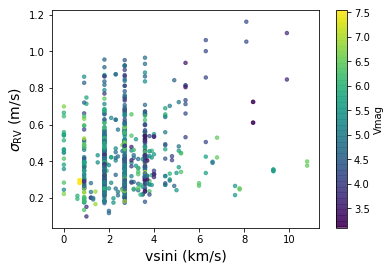

In [54]:
plt.scatter(vsinis, err_rvs, c=vmags, alpha=0.7, s=12)
plt.ylabel(r'$\sigma_{\mathrm{RV}}$ (m/s)', fontsize=14)
plt.xlabel('vsini (km/s)', fontsize=14)
plt.colorbar(label='Vmag');

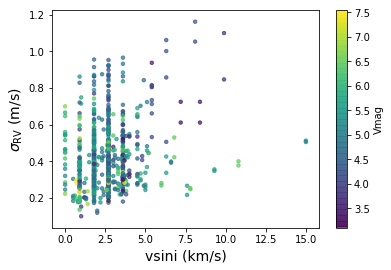

In [55]:
plt.scatter(t['vsini'], t['precision1'], c=t['VMAG'], alpha=0.7, s=12)
plt.scatter(t['vsini'], t['precision2'], c=t['VMAG'], alpha=0.7, s=12)
plt.ylabel(r'$\sigma_{\mathrm{RV}}$ (m/s)', fontsize=14)
plt.xlabel('vsini (km/s)', fontsize=14)
plt.colorbar(label='Vmag');

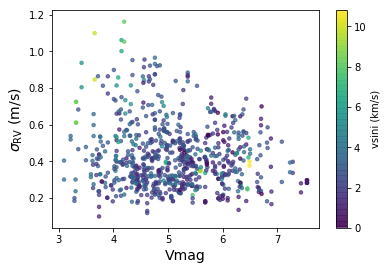

In [25]:
plt.scatter(vmags, err_rvs, c=vsinis, alpha=0.7, s=12)
plt.ylabel(r'$\sigma_{\mathrm{RV}}$ (m/s)', fontsize=14)
plt.xlabel('Vmag', fontsize=14)
plt.colorbar(label='vsini (km/s)');

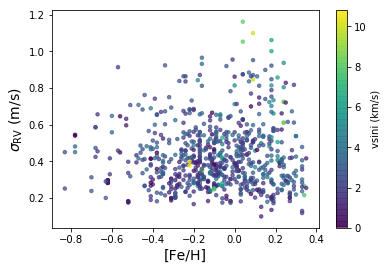

In [26]:
plt.scatter(fehs, err_rvs, c=vsinis, alpha=0.7, s=12)
plt.ylabel(r'$\sigma_{\mathrm{RV}}$ (m/s)', fontsize=14)
plt.xlabel('[Fe/H]', fontsize=14)
plt.colorbar(label='vsini (km/s)');

In [57]:
from astropy.io import ascii
ascii.write(t, 'gto-with-precision.csv', format='csv', overwrite=True)

#### HERMES spectrum